# Analyzing the dataset

In [1]:
from collections import Counter
from itertools import chain
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from statistics import mean, variance
from wordcloud import WordCloud

import contractions
import emoji
import matplotlib.pyplot as plt
import pandas
import re
import string

## Getting the Data

In [2]:
data = pandas.read_csv("../data/train-balanced-sarcasm.csv", index_col=False)

In [3]:
data.dropna(inplace = True)
data['label'] = data['label'].astype('int64')
data['comment'] = data['comment'].astype('string')
data['parent_comment'] = data['parent_comment'].astype('string')

In [4]:
display(data)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [5]:
print("Data was collected from %d users and %d subreddits." % (data["author"].nunique(), data["subreddit"].nunique()))

Data was collected from 256560 users and 14876 subreddits.


### Drop the columns we will not work on

In [6]:
data.drop(columns=["author", "subreddit", "score", "ups", "downs", "date", "created_utc"], inplace=True)

In [7]:
data.dtypes

label              int64
comment           string
parent_comment    string
dtype: object

## Lowercase and clean from punctuations, and filter long text

In [8]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    
    if len(text) > 500:
        return None
        
    text = contractions.fix(text)
    text = text.lower()
    
    text = text.replace('.', ' PERIOD ')
    text = text.replace(',', ' COMMA ')
    text = text.replace('"', ' QUOTATIONMARK ')
    text = text.replace(';', ' SEMICOLON ')
    text = text.replace('!', ' EXCLAMATIONMARK ')
    text = text.replace('?', ' QUESTION_MARK ')
    text = text.replace('(', ' LEFTPAREN ')
    text = text.replace(')', ' RIGHT_PAREN ')
    text = text.replace('--', ' HYPHENS ')
    text = text.replace('?', ' QUESTIONMARK ')
    text = text.replace('\n', ' NEWLINE ')
    text = text.replace(':', ' COLON ')
    
    text = emoji.demojize(text)
    
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = word_tokenize(text)
    text = " ".join([token for token in tokens if token not in stop_words])
    
    # Drop row if the comment is empty after cleaning
    if text.strip() == "":
        return None

    return text

In [9]:
data['comment'] = data['comment'].apply(clean_text)
print("[COMMENTS CLEANED]")

data['parent_comment'] = data['parent_comment'].apply(clean_text)
print("[PARENT COMMENTS CLEANED]")


data = data.dropna(subset=['label'])
data = data.dropna(subset=['comment'])
data = data.dropna(subset=['parent_comment'])

data = data.reset_index(drop=True)

[COMMENTS CLEANED]
[PARENT COMMENTS CLEANED]


In [10]:
display(data)

,label,comment,parent_comment
0,0,nc nh PERIOD,yeah COMMA get argument PERIOD point COMMA wou...
1,0,know west teams play west teams east teams rig...,blazers mavericks LEFTPAREN wests 5 6 seed RIG...
2,0,underdogs earlier today COMMA since gronks ann...,favored win PERIOD
3,0,meme funny none QUOTATIONMARK new york nigga Q...,deadass kill buzz
4,0,could use one tools PERIOD,yep confirm saw tool use PERIOD made boy easpo...
...,...,...,...
969658,1,sure iran n PERIOD korea technology create pig...,one calling engineered pathogen COMMA reports ...
969659,1,whatever COMMA vote green EXCLAMATIONMARK,move typical recent donothing approach co2 emi...
969660,1,perhaps atheist conspiracy make christians loo...,screw disabled HYPHENS got get church time
969661,1,slavs got country called kosovo,always unsettled PERIOD hear lot jewish people...


## Stats

In [11]:
data["label"].value_counts()

1    486665
0    482998
Name: label, dtype: int64

In [12]:
comments = [txt for txt in data['comment']]
parent_comments = [txt for txt in data['parent_comment']]
labels = list(data["label"])

In [13]:
comment_lengths = [len(text) for text in comments]
parent_lengths = [len(text) for text in parent_comments]

print("PARENT COMMENTS: [Average length: %.2f] [Variance: %.2f]" % (mean(parent_lengths), variance(parent_lengths)))
print("COMMENTS: [Average length: %.2f] [Variance: %.2f]" % (mean(comment_lengths), variance(comment_lengths)))

PARENT COMMENTS: [Average length: 88.70] [Variance: 5961.03]
COMMENTS: [Average length: 47.01] [Variance: 1155.88]


In [14]:
sarc_comments = [comment for idx, comment in enumerate(comments) if labels[idx]==1]
nsarc_comments = [comment for idx, comment in enumerate(comments) if labels[idx]==0]

In [15]:
sarc_lengths = [len(text) for text in sarc_comments]
nsarc_lengths = [len(text) for text in nsarc_comments]

print("SARCASTIC COMMENTS: [Average length: %.2f] [Variance: %.2f]" % (mean(sarc_lengths), variance(sarc_lengths)))
print("NON-SARCASTIC COMMENTS: [Average length: %.2f] [Variance: %.2f]" % (mean(nsarc_lengths), variance(nsarc_lengths)))

SARCASTIC COMMENTS: [Average length: 46.90] [Variance: 964.80]
NON-SARCASTIC COMMENTS: [Average length: 47.12] [Variance: 1348.39]


In [16]:
print("'%s' is sarcastic." % sarc_comments[100])
print("'%s' is NOT sarcastic." % nsarc_comments[100])

'yes suburban women totally relate trophy wife 5 days election PERIOD' is sarcastic.
'zip lines cool COMMA interested appears swimming pool underneath larger hometown PERIOD' is NOT sarcastic.


C:\Users\ahmet\AppData\Local\Temp\ipykernel_12104\2870652514.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


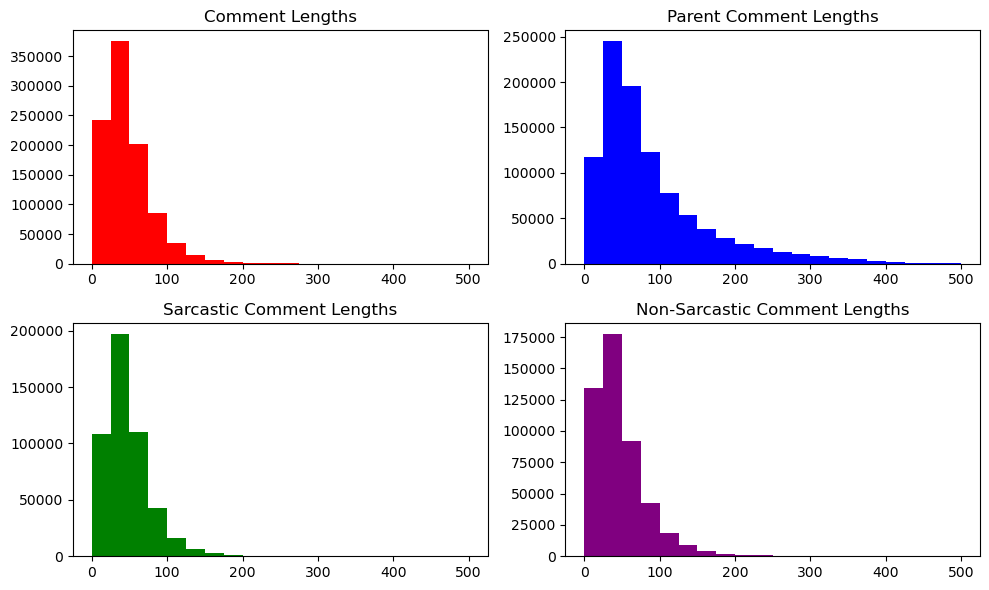

In [27]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))

ax1.hist(comment_lengths, 20, range=[0, 500], color="red")
ax1.title.set_text("Comment Lengths")
ax2.hist(parent_lengths, 20, range=[0, 500], color="blue")
ax2.title.set_text("Parent Comment Lengths")
ax3.hist(sarc_lengths, 20, range=[0, 500], color="green")
ax3.title.set_text("Sarcastic Comment Lengths")
ax4.hist(nsarc_lengths, 20, range=[0, 500], color="purple")
ax4.title.set_text("Non-Sarcastic Comment Lengths")

fig.tight_layout()
fig.show()

## Top words

In [28]:
sarc_comments = [text.split() for text in sarc_comments]
nsarc_comments = [text.split() for text in nsarc_comments]

sarc_comments = list(chain.from_iterable(sarc_comments))
nsarc_comments = list(chain.from_iterable(nsarc_comments))

In [29]:
print("Most popular in sarcastic:")
print([x[0] for x in Counter(sarc_comments).most_common(20)])
print("Most popular in non-sarcastic: ")
print([x[0] for x in Counter(nsarc_comments).most_common(20)])

Most popular in sarcastic:
['PERIOD', 'COMMA', 'EXCLAMATIONMARK', 'QUESTION_MARK', 'QUOTATIONMARK', 'yeah', 'like', 'would', 'people', 'well', 'get', 'know', 'right', 'one', 'good', 'sure', 'yes', 'us', 'think', 'oh']
Most popular in non-sarcastic: 
['PERIOD', 'COMMA', 'QUESTION_MARK', 'QUOTATIONMARK', 'would', 'like', 'EXCLAMATIONMARK', 'COLON', 'RIGHT_PAREN', 'one', 'get', 'LEFTPAREN', 'think', 'people', 'know', 'well', 'good', 'really', 'time', 'going']


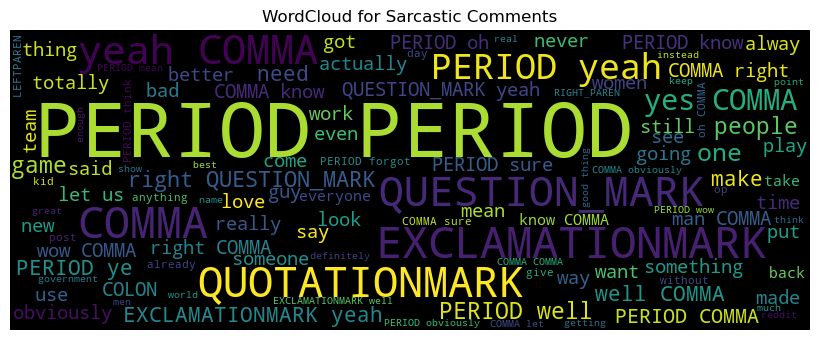

In [30]:
wordcloud = WordCloud(width = 800, height = 300,
                background_color ='black',
                min_font_size = 10).generate(" ".join([w for w in sarc_comments]))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("WordCloud for Sarcastic Comments")
plt.tight_layout(pad = 0)
 
plt.show()

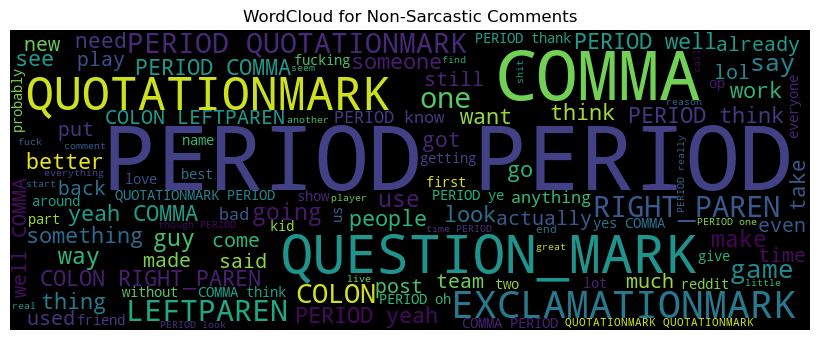

In [31]:
wordcloud = WordCloud(width = 800, height = 300,
                background_color ='black',
                min_font_size = 10).generate(" ".join([w for w in nsarc_comments]))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("WordCloud for Non-Sarcastic Comments")
plt.tight_layout(pad = 0)
 
plt.show()